# Vehicle Sales Price Predictions Workshop - Part 2 of 3

## Training Pipeline

In order to make a machine learning system from this dataset, we have structured the service into 3 pipelines:

1. feature engineering pipeline notebook (see Part 1)
2. training pipeline notebook (ie. this Part 2)
3. inferencing pipeline notebook (see Part 3)

This notebook will outline the second step, ie. the training pipeline.


### 5. PREPARING THE DATA 

A machine learning model is a mathematical equation. An equation cannot accept anything other than numbers. Your categorical data must therefore be transformed (encoded) into numerical data at this stage. However, if you encode the data, you must also save the encoder for later decoding once the model is trained.

In [ ]:
# Install the Hopsworks client library
!pip install --quiet hopsworks

In [25]:
# Connect to the Hopsworks Feature store and get the feature group
import hopsworks
proj = hopsworks.login()
fs = proj.get_feature_store()
fg = fs.get_feature_group(name="car_prices", version=1)

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Multiple projects found. 

	 (1) GraphEmbeddingsDemo
	 (2) rixdemo
	 (3) Car_Prices
	 (4) BeerVolumePrediction

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/818324
Connected. Call `.close()` to terminate connection gracefully.


In [26]:
# Create a feature view for the training
feature_view = fs.get_or_create_feature_view(name="car_prices",
                                             version=2,
                                             query= fg.select_except(["seller", "saledate"]),
                                             labels=["sellingprice"]
                                             )

In [27]:
# Now we can load the training data into a dataframe
import pandas as pd

features_df, labels_df = feature_view.training_data()
labels_df
features_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.73s) 
2024-06-20 17:52:23,234 WARNING: VersionWarning: Incremented version to `3`.



,year,make,model,trim,body,transmission,condition,odometer,color,interior
0,2003,Mercury,Mountaineer,Convenience,SUV,automatic,31.0,86584.0,silver,gray
1,2007,Chevrolet,Tahoe,LT,SUV,automatic,26.0,100833.0,white,gray
2,2001,Acura,TL,3.2,Sedan,automatic,46.0,241875.0,black,black
3,2002,Nissan,Maxima,GLE,Sedan,automatic,28.0,153046.0,gold,tan
4,2011,Toyota,Tacoma,V6,Double Cab,automatic,44.0,57316.0,silver,gray
...,...,...,...,...,...,...,...,...,...,...
70214,2012,Lexus,IS 250,Base,Sedan,automatic,19.0,16837.0,gray,black
70215,2009,Ford,F-350 Super Duty,XL,Crew Cab,manual,25.0,79124.0,white,gray
70216,2003,GMC,Yukon,Denali,SUV,automatic,28.0,146113.0,black,tan
70217,2006,Saab,9-3,Aero,Convertible,automatic,23.0,48079.0,blue,gray


In [28]:
# Now we will encode the dataset

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
import joblib

def encode_categorical_data(dataset, label_encoders):
    # Iterate over the columns of the DataFrame
    for column in dataset.columns:
        # Check if the column is of type 'object' (categorical)
        if dataset[column].dtype == 'object':
            # Create a LabelEncoder instance
            label_encoder = LabelEncoder()

            # Perform encoding on unique column values
            dataset[column] = label_encoder.fit_transform(dataset[column])

            # Add the encoder label to the dictionary
            label_encoders[column] = label_encoder
    return dataset

# Create a dictionary to store label encoders
clf = {}
df_encoded = encode_categorical_data(features_df, clf)
df_encoded

,year,make,model,trim,body,transmission,condition,odometer,color,interior
0,2003,31,403,412,31,0,31.0,86584.0,15,6
1,2007,7,578,657,31,0,26.0,100833.0,17,6
2,2001,0,572,167,32,0,46.0,241875.0,1,1
3,2002,33,382,540,32,0,28.0,153046.0,6,13
4,2011,45,577,1057,11,0,44.0,57316.0,15,6
...,...,...,...,...,...,...,...,...,...,...
70214,2012,24,302,321,32,0,19.0,16837.0,7,1
70215,2009,12,225,1129,9,1,25.0,79124.0,17,6
70216,2003,13,654,429,31,0,28.0,146113.0,1,13
70217,2006,39,33,302,7,0,23.0,48079.0,2,6


Transform categorical values ​​from dataset 'dataset_cleaned.csv' into numeric values ​​and saves the encoder to a file for later use during prediction.

Cut the encoded dataset into two parts, train and test Keep 1000 data in the test dataset`

In [29]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_encoded, labels_df, test_size=1000, random_state=42)

# Show training and test set sizes
print("Size of the training dataset :", len(X_train))
print("Size of the test dataset :", len(X_test))

Size of the training dataset : 69219
Size of the test dataset : 1000


### 6. TRAINING OF THE MODEL

Entraîne un modèle de régression utilisant une architecture de neurones profondes. La colonne à calculer est "sellingprice". Utilise la fonction de perte mean absolute error et la librairie pytorch

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Converting data to PyTorch tensorsX_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Creation of datasetstrain_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Model definition
class DeepRegressor(nn.Module):
    def __init__(self, input_size):
        super(DeepRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialisation of the model
model = DeepRegressor(input_size=X_train_tensor.shape[1])

# Definition of loss function and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training of the model
num_epochs = 50
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Evaluation of the model
model.eval()
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loss = 0.0

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        test_loss += loss.item() * inputs.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")


2024-06-20 17:52:34,302 WARNING: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

2024-06-20 17:52:35,242 WARNING: UserWarning: Using a target size (torch.Size([3, 1])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Epoch 1/50, Loss: 7079.4617
Epoch 2/50, Loss: 6968.0571
Epoch 3/50, Loss: 6948.2935
Epoch 4/50, Loss: 6945.9548
Epoch 5/50, Loss: 6934.9518
Epoch 6/50, Loss: 6938.5635
Epoch 7/50, Loss: 6935.0681
Epoch 8/50, Loss: 6933.5950
Epoch 9/50, Loss: 6927.7191
Epoch 10/50, Loss: 6933.7996
Epoch 11/50, Loss: 6934.4348
Epoch 12/50, Loss: 6928.7648
Epoch 13/50, Loss: 6930.6355
Epoch 14/50, Loss: 6926.4625
Epoch 15/50, Loss: 6932.1697
Epoch 16/50, Loss: 6926.3835
Epoch 17/50, Loss: 6928.2426
Epoch 18/50, Loss: 692

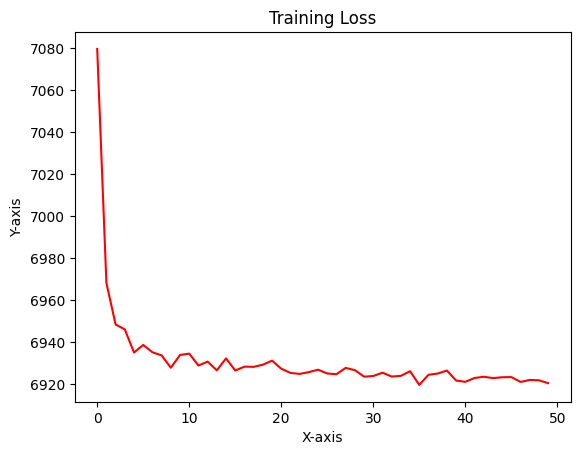

In [31]:
## Graphical representation of the model training results
import matplotlib.pyplot as plt
import numpy as np

plt.title('Training Loss')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

plt.plot(np.array(losses), 'r')
plt.show()

To minimize the error, do not hesitate to:

1. Test different neuronal architectures (more layers of neurons)
2. Change hyper parameters (more epochs, other learning rate, etc.)
3. Normalize your data before training during the data preparation phase. If you do so, remember to rescale (denormalize) before making predictions.

### 7. SAVE THE MODEL TO A FILE FOR LATER USE

Sauvegarde le modèle entier entraîné dans un fichier pour l'utiliser après et le mettre en production

In [32]:
# This step will upload the model to the Hopsworks Model Registry

import os
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib

input_schema = Schema(features_df)
output_schema = Schema(labels_df)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

model_name = "car_prices"

os.makedirs(model_name + "/images", exist_ok=True)

plt.savefig(model_name + "/images/training_losses.png")
plt.close()
# Saving the model
torch.save(model, model_name + '/regression_model.pth')
joblib.dump(clf, model_name + '/label_encoders.pkl')

mr = proj.get_model_registry()

car_prices_model = mr.torch.create_model(
    model_name,
    model_schema=model_schema,
    metrics = {'test_loss' : test_loss}
)

# Save the created model in the "car_prices_model" directory
car_prices_model.save(model_name)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/38202 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/23458 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/2396 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/865 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/818324/models/car_prices/1


Model(name: 'car_prices', version: 1)

Now we can proceed to the Inference Pipeline of the workshop demo example.